In [1]:
import numpy as np 
import pandas as pd 


import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.svm import OneClassSVM


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Using TensorFlow backend.


In [2]:
data = pd.read_csv('uci-secom.csv')

print(data.shape)


(1567, 592)


In [3]:
data.head()

,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [4]:
data.isnull().any().any()

True

In [5]:
data = data.replace(np.NaN, 0)

data.isnull().any().any()

False

In [6]:
unique_vals = data['Pass/Fail'].unique()  # [0, 1, 2]
targets = [data.loc[data['Pass/Fail'] == val] for val in unique_vals]

/root/anaconda3/envs/exp1/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/root/anaconda3/envs/exp1/lib/python3.6/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/root/anaconda3/envs/exp1/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/root/anaconda3/envs/ex

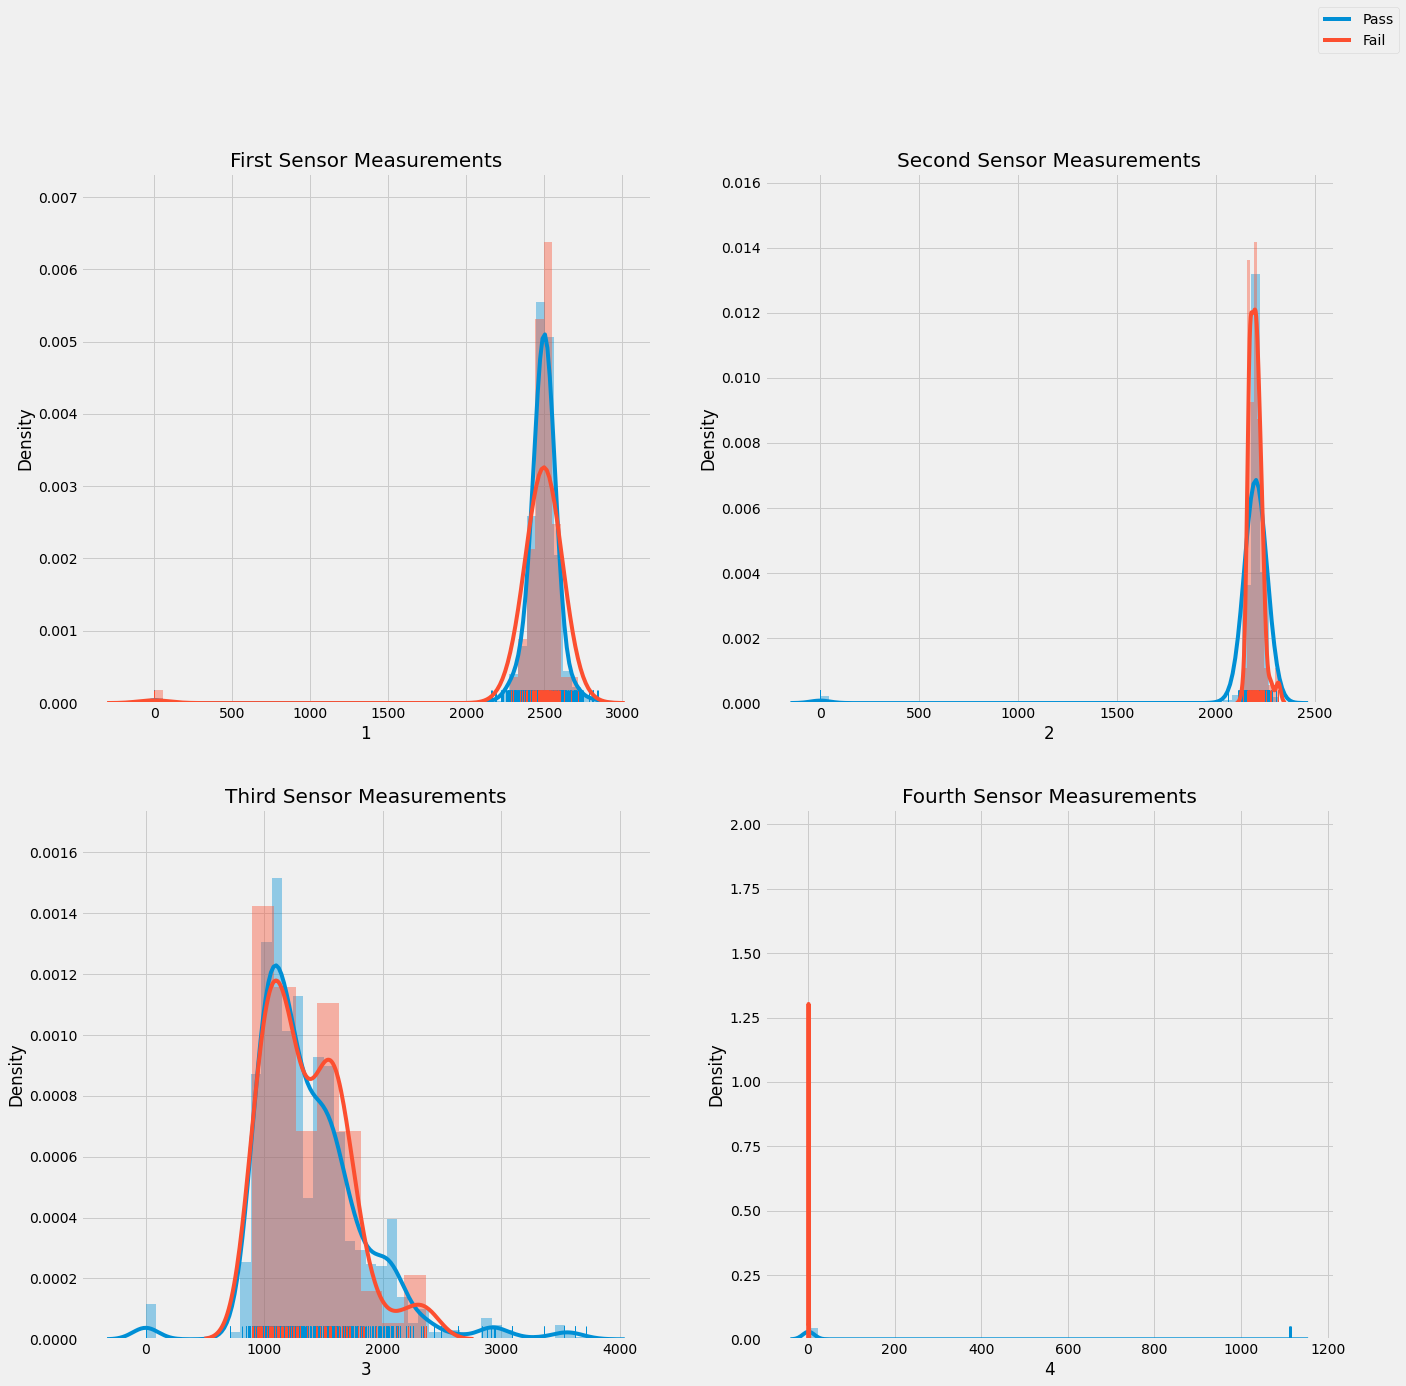

In [7]:
fig = plt.figure(figsize=(20,20))

plt.subplot(2, 2, 1)
for target in targets:
    sns.distplot(target['1'], hist=True, rug=True)
plt.title('First Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 2)
for target in targets:
    sns.distplot(target['2'], hist=True, rug=True)
plt.title('Second Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 3)
for target in targets:
    sns.distplot(target['3'], hist=True, rug=True)
plt.title('Third Sensor Measurements', fontsize = 20)

plt.subplot(2, 2, 4)
for target in targets:
    sns.distplot(target['4'], hist=True, rug=True)
plt.title('Fourth Sensor Measurements', fontsize = 20)


fig.legend(labels=['Pass','Fail'])
plt.show()


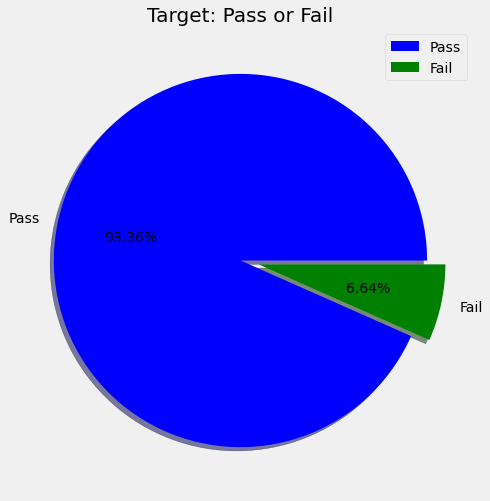

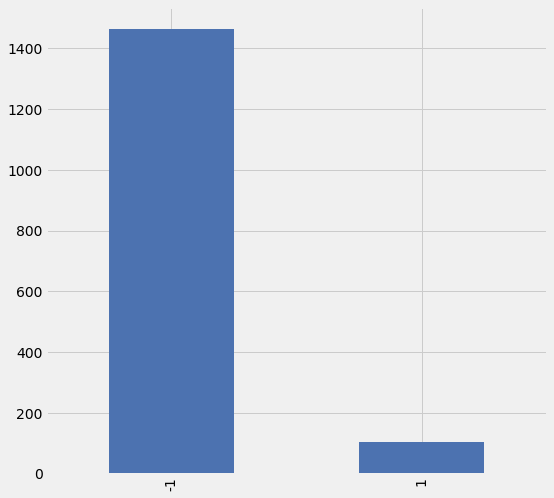

In [8]:
labels = ['Pass', 'Fail']
size = data['Pass/Fail'].value_counts()
colors = ['blue', 'green']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels =labels, colors = colors, explode = explode, autopct = "%.2f%%", shadow = True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize = 20)
plt.legend()
plt.show()
data['Pass/Fail'].value_counts().plot(kind="bar");

Text(0.5, 1.0, 'Correlation heatmap for the Data')

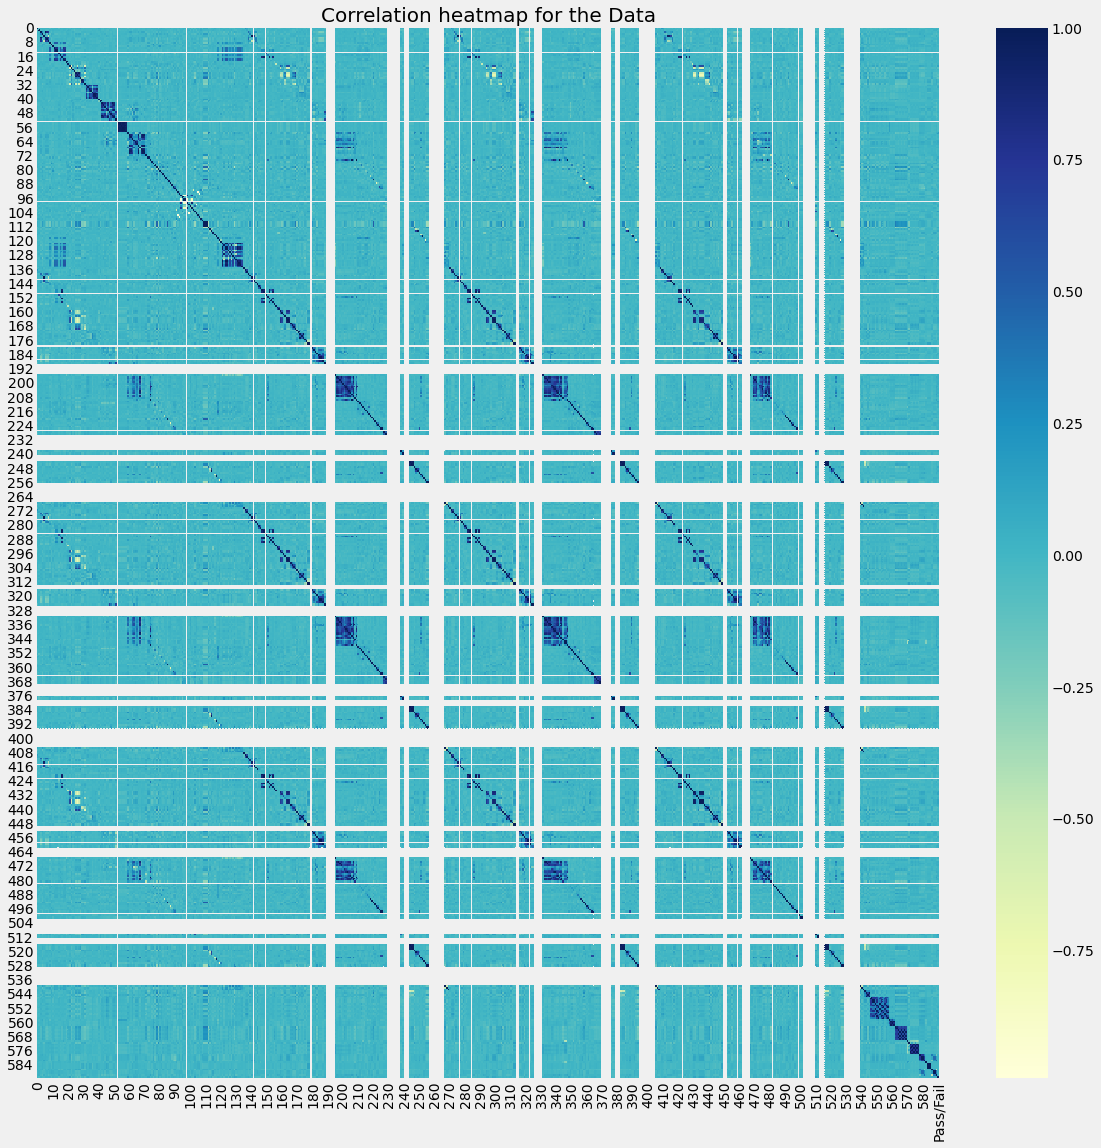

In [9]:
plt.rcParams['figure.figsize'] = (18, 18)
sns.heatmap(data.corr(), cmap = "YlGnBu")
plt.title('Correlation heatmap for the Data', fontsize = 20)

In [10]:
def remove_collinear_features(x, threshold):

    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            if val >= threshold:

                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [11]:
data = remove_collinear_features(data,0.70)

5 | 2 | 0.99
6 | 2 | 0.82
6 | 5 | 0.84
7 | 2 | 0.75
7 | 5 | 0.77
12 | 11 | 0.83
17 | 11 | 0.81
18 | 11 | 0.72
18 | 12 | 0.79
18 | 17 | 0.9
22 | 21 | 0.75
26 | 25 | 0.83
27 | 25 | 0.98
27 | 26 | 0.79
30 | 29 | 0.86
34 | 32 | 0.88
35 | 34 | 0.83
37 | 32 | 0.75
37 | 34 | 0.75
38 | 32 | 0.72
38 | 34 | 0.72
38 | 36 | 0.71
38 | 37 | 0.97
39 | 32 | 0.81
39 | 34 | 0.91
39 | 35 | 0.71
39 | 37 | 0.86
39 | 38 | 0.84
43 | 42 | 0.82
44 | 42 | 0.82
46 | 42 | 0.84
46 | 43 | 0.84
46 | 45 | 0.74
48 | 44 | 0.77
49 | 42 | 1.0
49 | 43 | 0.82
49 | 44 | 0.82
49 | 46 | 0.84
50 | 42 | 0.88
50 | 43 | 0.9
50 | 46 | 0.97
50 | 49 | 0.88
51 | 47 | 0.71
54 | 53 | 1.0
55 | 53 | 0.95
55 | 54 | 0.95
56 | 53 | 0.98
56 | 54 | 0.97
56 | 55 | 0.96
57 | 53 | 0.97
57 | 54 | 0.96
57 | 55 | 0.98
57 | 56 | 0.99
58 | 53 | 0.93
58 | 54 | 0.93
58 | 55 | 0.92
58 | 56 | 0.96
58 | 57 | 0.94
61 | 60 | 0.88
65 | 64 | 0.85
66 | 60 | 0.97
66 | 61 | 0.84
66 | 62 | 0.75
68 | 60 | 0.85
68 | 61 | 0.87
68 | 66 | 0.85
69 | 60 | 0.96
69 | 61 |

425 | 16 | 0.92
425 | 147 | 0.87
425 | 148 | 0.96
425 | 152 | 0.98
425 | 154 | 0.86
425 | 282 | 0.87
425 | 283 | 0.96
425 | 287 | 0.97
425 | 289 | 0.86
425 | 420 | 0.88
425 | 421 | 0.95
426 | 153 | 1.0
426 | 288 | 0.99
427 | 16 | 0.89
427 | 147 | 0.82
427 | 148 | 0.95
427 | 152 | 0.91
427 | 154 | 1.0
427 | 282 | 0.82
427 | 283 | 0.95
427 | 287 | 0.91
427 | 289 | 0.99
427 | 420 | 0.83
427 | 421 | 0.97
427 | 425 | 0.88
428 | 155 | 1.0
428 | 290 | 0.96
429 | 156 | 1.0
429 | 291 | 0.99
430 | 159 | 0.87
430 | 163 | 0.83
430 | 164 | 0.88
430 | 165 | 0.85
430 | 294 | 0.89
430 | 298 | 0.84
430 | 299 | 0.87
430 | 300 | 0.85
431 | 160 | 0.81
431 | 163 | 0.81
431 | 164 | 0.85
431 | 165 | 0.81
431 | 294 | 0.72
431 | 295 | 0.83
431 | 298 | 0.83
431 | 299 | 0.85
431 | 300 | 0.82
431 | 430 | 0.9
434 | 26 | 0.77
434 | 159 | 0.71
434 | 163 | 0.88
434 | 164 | 0.9
434 | 165 | 0.86
434 | 294 | 0.75
434 | 298 | 0.89
434 | 299 | 0.89
434 | 300 | 0.86
434 | 430 | 0.95
434 | 431 | 0.93
435 | 26 | 0.77
435 | 1

In [12]:
data = data.drop(columns = ['Time'], axis = 1)

data.shape

(1567, 307)

In [13]:
data.head()

,0,1,2,3,4,8,9,10,11,13,...,570,571,572,578,582,583,586,587,589,Pass/Fail
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,1.5005,0.0162,-0.0034,0.9455,0.0,...,533.8500,2.1113,8.95,0.0000,0.5005,0.0118,0.0000,0.0000,0.0000,-1
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,1.4966,-0.0005,-0.0148,0.9627,0.0,...,535.0164,2.4335,5.92,0.0096,0.5019,0.0223,0.0096,0.0201,208.2045,-1
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,1.4436,0.0041,0.0013,0.9615,0.0,...,535.0245,2.0293,11.21,0.0584,0.4958,0.0157,0.0584,0.0484,82.8602,1
3,2988.72,2479.90,2199.0333,909.7926,1.3204,1.4882,-0.0124,-0.0033,0.9629,0.0,...,530.5682,2.0253,9.33,0.0202,0.4990,0.0103,0.0202,0.0149,73.8432,-1
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,1.5031,-0.0031,-0.0072,0.9569,0.0,...,532.0155,2.0275,8.83,0.0000,0.4800,0.4766,0.0202,0.0149,73.8432,-1


In [14]:
x = data.iloc[:,:306]
y = data["Pass/Fail"]

print("shape of x:", x.shape)
print("shape of y:", y.shape)

shape of x: (1567, 306)
shape of y: (1567,)


In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 1)

print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (1096, 306)
shape of x_test:  (471, 306)
shape of y_train:  (1096,)
shape of y_test:  (471,)


In [16]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)


In [17]:
model = XGBClassifier(random_state=1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

[07:20:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/root/anaconda3/envs/exp1/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


<AxesSubplot:>

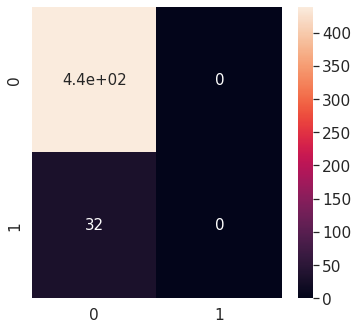

In [18]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [19]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  93.20594479830149


In [20]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

<AxesSubplot:>

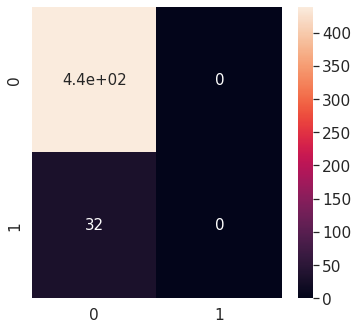

In [21]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [22]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  93.20594479830149


In [23]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train, y_train) 
y_pred = lr.predict(x_test)

<AxesSubplot:>

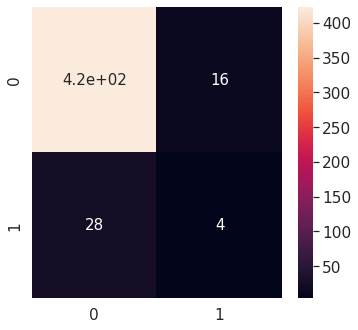

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

In [25]:
print("Accuracy: ", lr.score(x_test,y_test)*100)

Accuracy:  90.65817409766454


In [26]:

lasso = Lasso(alpha=0.1,random_state=1)
lasso.fit(x_train,y_train)

y_pred = lasso.predict(x_test)

y_pred2 = np.sign(y_pred)

In [27]:
print("Accuracy: ", lasso.score(x_test,y_test)*100)

Accuracy:  -0.007974076019068299


<AxesSubplot:>

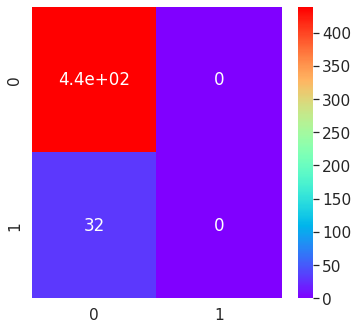

In [28]:
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

In [29]:
failed_tests = np.array(data[data['Pass/Fail'] == 1].index)
no_failed_tests = len(failed_tests)

print(no_failed_tests)

104


In [30]:
normal_indices = data[data['Pass/Fail'] == -1]
no_normal_indices = len(normal_indices)

print(no_normal_indices)

1463


In [31]:
random_normal_indices = np.random.choice(no_normal_indices, size = no_failed_tests, replace = True)
random_normal_indices = np.array(random_normal_indices)

print(len(random_normal_indices))

104


In [32]:
under_sample = np.concatenate([failed_tests, random_normal_indices])
print(len(under_sample))

208


In [33]:

undersample_data = data.iloc[under_sample, :]

In [34]:
x = undersample_data.iloc[:, undersample_data.columns != 'Pass/Fail'] 
y = undersample_data.iloc[:, undersample_data.columns == 'Pass/Fail']

print(x.shape)
print(y.shape)

(208, 306)
(208, 1)


In [35]:
from sklearn.model_selection import train_test_split

x_train_us, x_test_us, y_train_us, y_test_us = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_us.shape)
print(y_train_us.shape)
print(x_test_us.shape)
print(y_test_us.shape)

(145, 306)
(145, 1)
(63, 306)
(63, 1)


In [36]:
sc = StandardScaler()
x_train_us = sc.fit_transform(x_train_us)
x_test_us = sc.transform(x_test_us)

In [37]:


model = XGBClassifier(random_state=1)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

[07:20:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/root/anaconda3/envs/exp1/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/root/anaconda3/envs/exp1/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<AxesSubplot:>

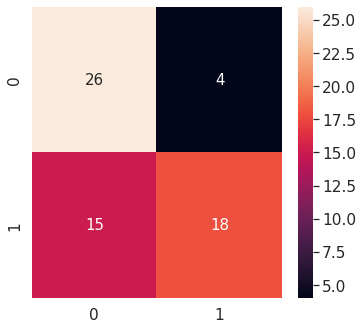

In [38]:


cm = confusion_matrix(y_test_us, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})


In [39]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  53.07855626326964


In [40]:
parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
              'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy',  n_jobs = -1)

grid_search = grid_search.fit(x_train_us, y_train_us)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

/root/anaconda3/envs/exp1/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/root/anaconda3/envs/exp1/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[07:26:23] WARNING: ../src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:26:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [41]:
print("Best Accuracy: ", best_accuracy*100)
print("Best Parameter: ", best_parameters)

Best Accuracy:  65.51724137931035
Best Parameter:  {'cv': 2, 'max_depth': 4, 'random_state': 1}


In [42]:


weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)

model.fit(x_train_us, y_train_us)

y_pred = model.predict(x_test_us)

[07:26:23] WARNING: ../src/learner.cc:576: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:26:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/root/anaconda3/envs/exp1/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/root/anaconda3/envs/exp1/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [43]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  57.961783439490446


<AxesSubplot:>

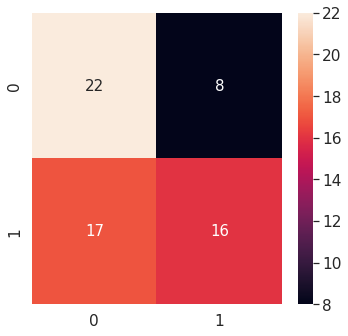

In [44]:
cm = confusion_matrix(y_test_us, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15})

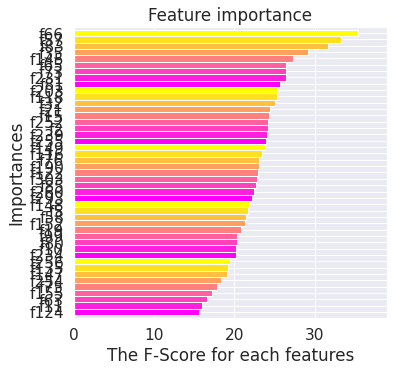

In [45]:
colors = plt.cm.spring(np.linspace(0, 1, 9))
xgb.plot_importance(model, height = 1, color = colors, grid = True, importance_type = 'cover', show_values = False)

plt.rcParams['figure.figsize'] = (100, 100)
plt.xlabel('The F-Score for each features')
plt.ylabel('Importances')
plt.show()

In [46]:


x_resample, y_resample  = SMOTE(random_state=1).fit_sample(x, y.values.ravel())

print(x_resample.shape)
print(y_resample.shape)

(214, 306)
(214,)


In [47]:


x_train_os, x_test_os, y_train_os, y_test_os = train_test_split(x, y, test_size = 0.3, random_state = 1)

print(x_train_os.shape)
print(y_train_os.shape)
print(x_test_os.shape)
print(y_test_os.shape)

(145, 306)
(145, 1)
(63, 306)
(63, 1)


In [48]:
sc = StandardScaler()
x_train_os = sc.fit_transform(x_train_os)
x_test_os = sc.transform(x_test_os)

In [49]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

model = XGBClassifier(random_state=1)

model.fit(x_train_os, y_train_os)

y_pred = model.predict(x_test_os)

[07:26:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/root/anaconda3/envs/exp1/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/root/anaconda3/envs/exp1/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [50]:
from sklearn.model_selection import GridSearchCV

parameters = [{'max_depth' : [1, 2, 3, 4, 5, 6],
              'cv' : [2,4,6,8,10],
              'random_state' : [1]}]

grid_search = GridSearchCV(estimator = model, param_grid = parameters, scoring = 'accuracy', n_jobs = -1)
grid_search = grid_search.fit(x_train_os, y_train_os)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_



/root/anaconda3/envs/exp1/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/root/anaconda3/envs/exp1/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[07:32:15] WARNING: ../src/learner.cc:576: 
Parameters: { "cv" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:32:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [51]:
print("Best Accuracy: ", best_accuracy)
print("Best Parameter: ", best_parameters)

Best Accuracy:  0.6551724137931034
Best Parameter:  {'cv': 2, 'max_depth': 4, 'random_state': 1}


In [52]:


weights = (y == 0).sum()/(1.0*(y == -1).sum())
model = XGBClassifier(max_depth = 1, scale_pos_weights = weights, n_jobs = 4,random_state=1,cv=2)

model.fit(x_train_os, y_train_os)

y_pred = model.predict(x_test_os)


[07:32:15] WARNING: ../src/learner.cc:576: 
Parameters: { "cv", "scale_pos_weights" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:32:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/root/anaconda3/envs/exp1/lib/python3.6/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/root/anaconda3/envs/exp1/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


<AxesSubplot:>

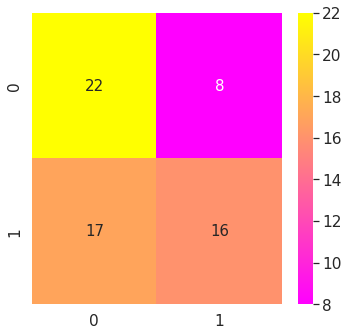

In [53]:


cm = confusion_matrix(y_test_os, y_pred)


plt.rcParams['figure.figsize'] = (5, 5)
sns.set(style = 'dark', font_scale = 1.4)
sns.heatmap(cm, annot = True, annot_kws = {"size": 15}, cmap = 'spring')

In [54]:
print("Accuracy: ", model.score(x_test,y_test)*100)

Accuracy:  57.961783439490446


In [55]:
model = RandomForestClassifier(n_estimators=100, random_state=1,verbose=0 )
model.fit(x_train_os, y_train_os)

y_pred = model.predict(x_test_os)
print("Accuracy: ", model.score(x_test_os,y_test_os)*100)

/root/anaconda3/envs/exp1/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy:  66.66666666666666


<AxesSubplot:>

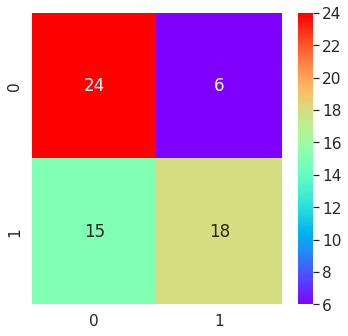

In [56]:
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')

In [57]:
lr = LogisticRegression(random_state=1)
lr.fit(x_train_os, y_train_os) 
y_pred = lr.predict(x_test_os)

print("Accuracy: ", lr.score(x_test_os,y_test_os)*100)

/root/anaconda3/envs/exp1/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Accuracy:  65.07936507936508


<AxesSubplot:>

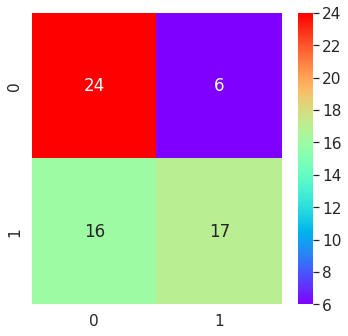

In [58]:
cm = confusion_matrix(y_test_os, y_pred)
sns.heatmap(cm, annot = True, cmap = 'rainbow')